## Bibiliothèque

In [1]:
import numpy as np
import tensorflow as tf;
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from Distiller import Distiller_AdaIn, Distiller
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline
seed = tf.random.set_seed(10)


2022-06-14 08:44:56.467955: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-14 08:44:56.467997: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Utils

In [2]:
def plot_hist_kd(hist, figname):
    #History
    plt.figure(figsize=(20,7))
    plt.subplot(121)
    plt.plot(hist.history['sparse_categorical_accuracy'], label = "train accur")
    plt.plot(hist.history['val_sparse_categorical_accuracy'], label = "Val accur")
    
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title("Accuracy")
    plt.grid()
    plt.legend()


    plt.subplot(122)
    plt.plot(hist.history['student_loss'], label = "student Loss")
    plt.plot(hist.history['val_student_loss'], label = "Val loss")
    plt.xlabel('Epochs')
    plt.ylabel('Student Loss')
    plt.title("Loss")
    plt.grid()
    plt.legend()
    
    plt.savefig(figname)
    
    plt.show()

## Loading cifar10 Dataset

In [3]:
print("================ Data Loading ================")
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Data shapes
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("")

================ Data Loading ================
x_train shape: (50000, 32, 32, 3)
x_test shape: (10000, 32, 32, 3)
y_train shape: (50000, 1)
y_test shape: (10000, 1)



## Loading Resnet26 Teacher model

In [4]:
print("")
print("================ Loading teacher model ================")
teacher = tf.keras.models.load_model("Resnet26_from_logits");
print("Evaluation of Teacher model!")
teacher.evaluate(x_test, y_test)
print("")



================ Loading teacher model ================


2022-06-14 08:45:16.843240: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-14 08:45:16.843296: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-14 08:45:16.843319: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (big26): /proc/driver/nvidia/version does not exist
2022-06-14 08:45:16.845125: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Evaluation of Teacher model!
313/313 [==============================] - 13s 38ms/step - loss: 0.5328 - sparse_categorical_accuracy: 0.9054



## Building a preprocessing routine

In [5]:
print(" ============== Adding preprocessing layers ===============")
preprocessing = tf.keras.Sequential([
    tf.keras.layers.RandomCrop(32, 32, seed= seed),
    tf.keras.layers.RandomFlip(mode="horizontal", seed= seed),

])

 ============== Adding preprocessing layers ===============


## Building Lenet5 Student model 

In [6]:
print("============== Building Student Network Lenet5 ! =============")

student = tf.keras.Sequential([
    preprocessing,
    tf.keras.layers.Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(32,32,3)),
    tf.keras.layers.AveragePooling2D(pool_size=(2,2), strides=2, padding="valid"),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu'),
    tf.keras.layers.AveragePooling2D(pool_size=(2,2), strides=2, padding="valid"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=120, activation='relu'),
    tf.keras.layers.Dense(units=84, activation='relu'),
    tf.keras.layers.Dense(units=10)

]);




============== Building Student Network Lenet5 ! =============


## Building callbacks

In [7]:
model_save = tf.keras.callbacks.ModelCheckpoint(
    "/callback/callback_save",
    monitor='val_student_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='auto',
    save_freq='epoch',
    options=None,
    initial_value_threshold=None,
)

lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_student_loss',
    factor=0.1,
    patience=10,
    verbose=1,
    mode='min',
    
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.000001,
)

lr_reduce2 = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=10,
    verbose=1,
    mode='min',
    
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.000001,
)

## Scratch training

In [8]:
student_scratch = tf.keras.Sequential([
    student,
    tf.keras.layers.Activation("softmax"),
    
])

In [9]:

BATCH_SIZE = 32
EPOCHS = 100
lr = 0.1

NAME = f"Lenet5_scratch"
tensorboard = tf.keras.callbacks.TensorBoard(log_dir = f"logs/{NAME}", 
                                                 histogram_freq = 1)


student_scratch.compile(
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr),
        metrics = [tf.keras.metrics.SparseCategoricalAccuracy()],
        loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        )

    # Train and evaluate on data.
hist = student_scratch.fit(x_train, y_train, 
      batch_size = BATCH_SIZE,
      epochs=EPOCHS,
      steps_per_epoch = len(x_train)/BATCH_SIZE,
      validation_data =(x_test, y_test),
      workers =40,
      use_multiprocessing= True,
      callbacks = [lr_reduce2, tensorboard],
      )


student_scratch.evaluate(x_test, y_test)

print("")

print("End !")

Epoch 1/100
1562/1562 [==============================] - 20s 12ms/step - loss: 1.9628 - sparse_categorical_accuracy: 0.2796 - val_loss: 1.6733 - val_sparse_categorical_accuracy: 0.3884 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 18s 11ms/step - loss: 1.6032 - sparse_categorical_accuracy: 0.4198 - val_loss: 1.7095 - val_sparse_categorical_accuracy: 0.4092 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 17s 11ms/step - loss: 1.4722 - sparse_categorical_accuracy: 0.4679 - val_loss: 1.4382 - val_sparse_categorical_accuracy: 0.4779 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 17s 11ms/step - loss: 1.3944 - sparse_categorical_accuracy: 0.4996 - val_loss: 1.4153 - val_sparse_categorical_accuracy: 0.5007 - lr: 0.1000
Epoch 5/100
1562/1562 [==============================] - 17s 11ms/step - loss: 1.3348 - sparse_categorical_accuracy: 0.5228 - val_loss: 1.3087 - val_sparse_categorical_accuracy: 0.5261 - lr: 0.1000
Epoch 6/10

1562/1562 [==============================] - 17s 11ms/step - loss: 0.5984 - sparse_categorical_accuracy: 0.7873 - val_loss: 1.1876 - val_sparse_categorical_accuracy: 0.6333 - lr: 0.0100
Epoch 42/100
1562/1562 [==============================] - 17s 11ms/step - loss: 0.5955 - sparse_categorical_accuracy: 0.7887 - val_loss: 1.1840 - val_sparse_categorical_accuracy: 0.6342 - lr: 0.0100
Epoch 43/100
1560/1562 [============================>.] - ETA: 0s - loss: 0.5866 - sparse_categorical_accuracy: 0.7929
Epoch 43: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
1562/1562 [==============================] - 17s 11ms/step - loss: 0.5870 - sparse_categorical_accuracy: 0.7927 - val_loss: 1.1950 - val_sparse_categorical_accuracy: 0.6334 - lr: 0.0100
Epoch 44/100
1562/1562 [==============================] - 17s 11ms/step - loss: 0.5699 - sparse_categorical_accuracy: 0.7989 - val_loss: 1.1934 - val_sparse_categorical_accuracy: 0.6363 - lr: 1.0000e-03
Epoch 45/100
1562/1562 [======

Epoch 78/100
1562/1562 [==============================] - 17s 11ms/step - loss: 0.5554 - sparse_categorical_accuracy: 0.8050 - val_loss: 1.2065 - val_sparse_categorical_accuracy: 0.6347 - lr: 1.0000e-06
Epoch 79/100
1562/1562 [==============================] - 17s 11ms/step - loss: 0.5534 - sparse_categorical_accuracy: 0.8049 - val_loss: 1.2065 - val_sparse_categorical_accuracy: 0.6347 - lr: 1.0000e-06
Epoch 80/100
1562/1562 [==============================] - 17s 11ms/step - loss: 0.5614 - sparse_categorical_accuracy: 0.8021 - val_loss: 1.2065 - val_sparse_categorical_accuracy: 0.6347 - lr: 1.0000e-06
Epoch 81/100
1562/1562 [==============================] - 17s 11ms/step - loss: 0.5583 - sparse_categorical_accuracy: 0.8050 - val_loss: 1.2065 - val_sparse_categorical_accuracy: 0.6347 - lr: 1.0000e-06
Epoch 82/100
1562/1562 [==============================] - 17s 11ms/step - loss: 0.5563 - sparse_categorical_accuracy: 0.8042 - val_loss: 1.2065 - val_sparse_categorical_accuracy: 0.6347 - 

## Knowledge distillation

In [10]:
BATCH_SIZE = 32
EPOCHS = 100
T = [ 5, 10, 15, 20, 25, 30, 35, 40, 100]
lr = 0.1


Epoch 1/100
1562/1562 [==============================] - 65s 41ms/step - sparse_categorical_accuracy: 0.2928 - student_loss: 2.3462 - Dist_loss: 1.5218 - loss: 1.6042 - val_sparse_categorical_accuracy: 0.3730 - val_student_loss: 2.5780 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 63s 40ms/step - sparse_categorical_accuracy: 0.4192 - student_loss: 2.2993 - Dist_loss: 1.2373 - loss: 1.3435 - val_sparse_categorical_accuracy: 0.4523 - val_student_loss: 1.5014 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 63s 40ms/step - sparse_categorical_accuracy: 0.4747 - student_loss: 2.2003 - Dist_loss: 1.1138 - loss: 1.2225 - val_sparse_categorical_accuracy: 0.4896 - val_student_loss: 1.6087 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 63s 40ms/step - sparse_categorical_accuracy: 0.5057 - student_loss: 2.1343 - Dist_loss: 1.0403 - loss: 1.1497 - val_sparse_categorical_accuracy: 0.4553 - val_student_loss: 1.5001 - lr: 0.1000
Epoc

Epoch 32/100
1562/1562 [==============================] - 63s 40ms/step - sparse_categorical_accuracy: 0.7172 - student_loss: 1.2815 - Dist_loss: 0.5939 - loss: 0.6627 - val_sparse_categorical_accuracy: 0.6312 - val_student_loss: 2.4635 - lr: 1.0000e-03
Epoch 33/100
1562/1562 [==============================] - 63s 40ms/step - sparse_categorical_accuracy: 0.7185 - student_loss: 1.2731 - Dist_loss: 0.5917 - loss: 0.6599 - val_sparse_categorical_accuracy: 0.6319 - val_student_loss: 2.4644 - lr: 1.0000e-03
Epoch 34/100
1562/1562 [==============================] - 63s 40ms/step - sparse_categorical_accuracy: 0.7197 - student_loss: 1.2735 - Dist_loss: 0.5912 - loss: 0.6594 - val_sparse_categorical_accuracy: 0.6320 - val_student_loss: 2.4572 - lr: 1.0000e-03
Epoch 35/100
1562/1562 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.7179 - student_loss: 1.2778 - Dist_loss: 0.5920 - loss: 0.6606
Epoch 35: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 62/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.7208 - student_loss: 1.2607 - Dist_loss: 0.5892 - loss: 0.6564 - val_sparse_categorical_accuracy: 0.6316 - val_student_loss: 2.4530 - lr: 1.0000e-06
Epoch 63/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.7193 - student_loss: 1.2681 - Dist_loss: 0.5895 - loss: 0.6573 - val_sparse_categorical_accuracy: 0.6316 - val_student_loss: 2.4530 - lr: 1.0000e-06
Epoch 64/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.7205 - student_loss: 1.2623 - Dist_loss: 0.5888 - loss: 0.6561 - val_sparse_categorical_accuracy: 0.6315 - val_student_loss: 2.4530 - lr: 1.0000e-06
Epoch 65/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.7177 - student_loss: 1.2722 - Dist_loss: 0.5910 - loss: 0.6591 - val_sparse_categorical_accuracy: 0.6315 - val_student_loss: 2.4530 -

1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.7188 - student_loss: 1.2699 - Dist_loss: 0.5908 - loss: 0.6587 - val_sparse_categorical_accuracy: 0.6314 - val_student_loss: 2.4533 - lr: 1.0000e-06
Epoch 95/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.7196 - student_loss: 1.2652 - Dist_loss: 0.5900 - loss: 0.6575 - val_sparse_categorical_accuracy: 0.6314 - val_student_loss: 2.4534 - lr: 1.0000e-06
Epoch 96/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.7211 - student_loss: 1.2668 - Dist_loss: 0.5901 - loss: 0.6578 - val_sparse_categorical_accuracy: 0.6314 - val_student_loss: 2.4534 - lr: 1.0000e-06
Epoch 97/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.7214 - student_loss: 1.2648 - Dist_loss: 0.5894 - loss: 0.6569 - val_sparse_categorical_accuracy: 0.6314 - val_student_loss: 2.4534 - lr: 1.0000e-

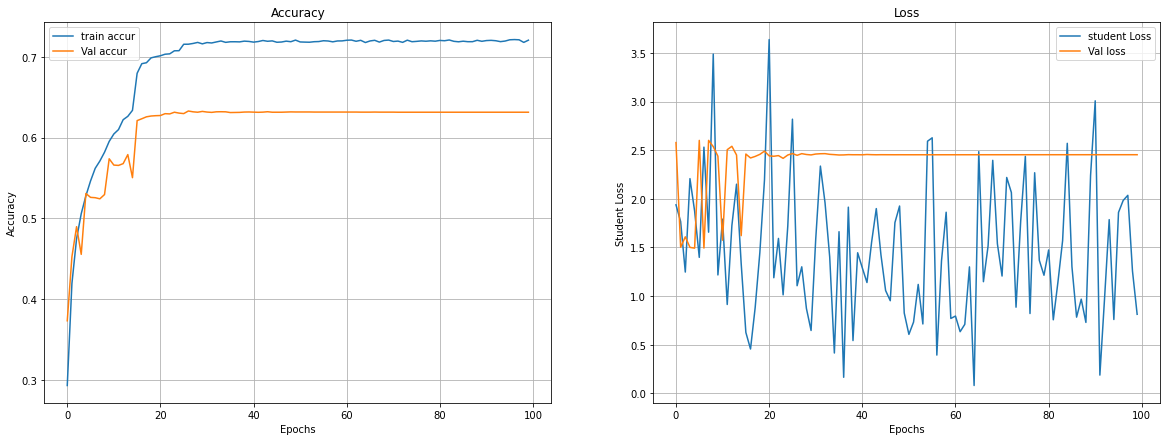

Saving model 


2022-06-14 10:58:37.243328: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: Lenet5_KD_temp5/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 65s 40ms/step - sparse_categorical_accuracy: 0.2720 - student_loss: 2.1509 - Dist_loss: 0.7932 - loss: 0.9290 - val_sparse_categorical_accuracy: 0.3359 - val_student_loss: 2.6215 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.3876 - student_loss: 2.0605 - Dist_loss: 0.6801 - loss: 0.8182 - val_sparse_categorical_accuracy: 0.4042 - val_student_loss: 3.5181 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.4372 - student_loss: 2.0224 - Dist_loss: 0.6195 - loss: 0.7598 - val_sparse_categorical_accuracy: 0.4615 - val_student_loss: 2.5368 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.4794 - student_loss: 1.9591 - Dist_loss:

1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.6969 - student_loss: 1.2907 - Dist_loss: 0.3194 - loss: 0.4165 - val_sparse_categorical_accuracy: 0.6302 - val_student_loss: 1.4412 - lr: 0.1000
Epoch 34/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.6994 - student_loss: 1.2775 - Dist_loss: 0.3163 - loss: 0.4124 - val_sparse_categorical_accuracy: 0.6400 - val_student_loss: 1.3443 - lr: 0.1000
Epoch 35/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.7050 - student_loss: 1.2530 - Dist_loss: 0.3117 - loss: 0.4058 - val_sparse_categorical_accuracy: 0.6389 - val_student_loss: 1.3256 - lr: 0.1000
Epoch 36/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.7082 - student_loss: 1.2450 - Dist_loss: 0.3086 - loss: 0.4023 - val_sparse_categorical_accuracy: 0.6344 - val_student_loss: 1.2882 - lr: 0.1000
Epoch 37/100


Epoch 64/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.7894 - student_loss: 0.8198 - Dist_loss: 0.2456 - loss: 0.3030 - val_sparse_categorical_accuracy: 0.6802 - val_student_loss: 1.3507 - lr: 1.0000e-03
Epoch 65/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.7903 - student_loss: 0.8217 - Dist_loss: 0.2450 - loss: 0.3026 - val_sparse_categorical_accuracy: 0.6799 - val_student_loss: 1.3504 - lr: 1.0000e-03
Epoch 66/100
1563/1562 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.7919 - student_loss: 0.8218 - Dist_loss: 0.2454 - loss: 0.3030
Epoch 66: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.7919 - student_loss: 0.8218 - Dist_loss: 0.2454 - loss: 0.3030 - val_sparse_categorical_accuracy: 0.6823 - val_student_loss: 1.3546 - lr: 1.0000e-03
Epoch 67/100

Epoch 94/100
1562/1562 [==============================] - 62s 39ms/step - sparse_categorical_accuracy: 0.7922 - student_loss: 0.8220 - Dist_loss: 0.2449 - loss: 0.3026 - val_sparse_categorical_accuracy: 0.6804 - val_student_loss: 1.3484 - lr: 1.0000e-06
Epoch 95/100
1562/1562 [==============================] - 62s 39ms/step - sparse_categorical_accuracy: 0.7912 - student_loss: 0.8195 - Dist_loss: 0.2452 - loss: 0.3026 - val_sparse_categorical_accuracy: 0.6804 - val_student_loss: 1.3484 - lr: 1.0000e-06
Epoch 96/100
1562/1562 [==============================] - 61s 39ms/step - sparse_categorical_accuracy: 0.7913 - student_loss: 0.8209 - Dist_loss: 0.2448 - loss: 0.3024 - val_sparse_categorical_accuracy: 0.6804 - val_student_loss: 1.3485 - lr: 1.0000e-06
Epoch 97/100
1562/1562 [==============================] - 62s 39ms/step - sparse_categorical_accuracy: 0.7928 - student_loss: 0.8174 - Dist_loss: 0.2445 - loss: 0.3018 - val_sparse_categorical_accuracy: 0.6804 - val_student_loss: 1.3485 -

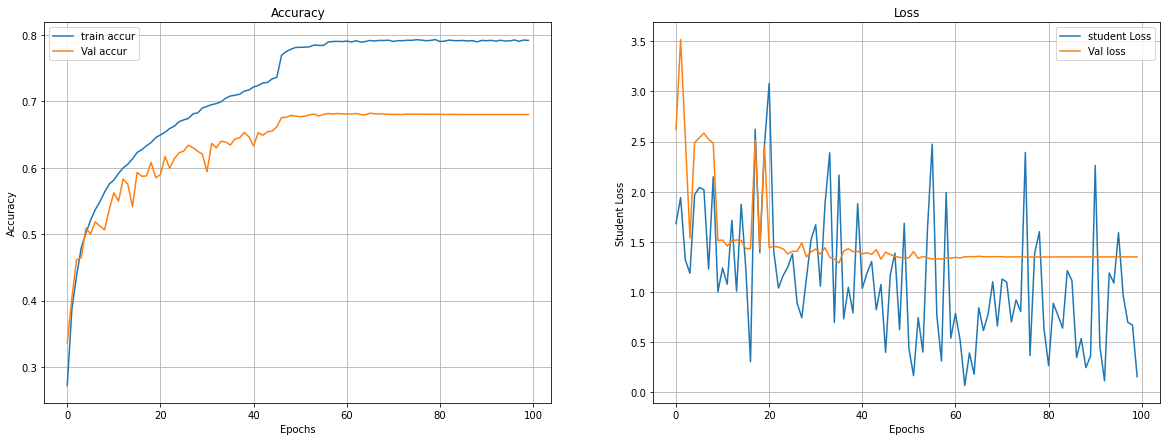

Saving model 
INFO:tensorflow:Assets written to: Lenet5_KD_temp10/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 64s 40ms/step - sparse_categorical_accuracy: 0.2695 - student_loss: 2.0309 - Dist_loss: 0.3984 - loss: 0.5617 - val_sparse_categorical_accuracy: 0.3301 - val_student_loss: 2.6427 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 62s 39ms/step - sparse_categorical_accuracy: 0.3899 - student_loss: 1.8083 - Dist_loss: 0.3503 - loss: 0.4961 - val_sparse_categorical_accuracy: 0.4095 - val_student_loss: 2.6302 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 62s 39ms/step - sparse_categorical_accuracy: 0.4391 - student_loss: 1.7263 - Dist_loss: 0.3231 - loss: 0.4635 - val_sparse_categorical_accuracy: 0.4610 - val_student_loss: 2.6844 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.4724 - student_loss: 1.65

1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.6586 - student_loss: 1.1682 - Dist_loss: 0.2030 - loss: 0.2995 - val_sparse_categorical_accuracy: 0.5963 - val_student_loss: 1.5509 - lr: 0.1000
Epoch 33/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.6596 - student_loss: 1.1590 - Dist_loss: 0.2015 - loss: 0.2973 - val_sparse_categorical_accuracy: 0.6032 - val_student_loss: 1.5113 - lr: 0.1000
Epoch 34/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.6632 - student_loss: 1.1518 - Dist_loss: 0.1997 - loss: 0.2949 - val_sparse_categorical_accuracy: 0.6048 - val_student_loss: 1.5132 - lr: 0.1000
Epoch 35/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.6649 - student_loss: 1.1429 - Dist_loss: 0.1986 - loss: 0.2930 - val_sparse_categorical_accuracy: 0.6056 - val_student_loss: 1.5167 - lr: 0.1000
Epoch 36/100


Epoch 62/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.7332 - student_loss: 0.8867 - Dist_loss: 0.1731 - loss: 0.2444 - val_sparse_categorical_accuracy: 0.6273 - val_student_loss: 1.5395 - lr: 1.0000e-04
Epoch 63/100
1562/1562 [==============================] - 62s 39ms/step - sparse_categorical_accuracy: 0.7356 - student_loss: 0.8845 - Dist_loss: 0.1732 - loss: 0.2443 - val_sparse_categorical_accuracy: 0.6280 - val_student_loss: 1.5391 - lr: 1.0000e-04
Epoch 64/100
1562/1562 [==============================] - 62s 39ms/step - sparse_categorical_accuracy: 0.7330 - student_loss: 0.8897 - Dist_loss: 0.1733 - loss: 0.2449 - val_sparse_categorical_accuracy: 0.6283 - val_student_loss: 1.5384 - lr: 1.0000e-04
Epoch 65/100
1562/1562 [==============================] - 62s 39ms/step - sparse_categorical_accuracy: 0.7331 - student_loss: 0.8926 - Dist_loss: 0.1732 - loss: 0.2452 - val_sparse_categorical_accuracy: 0.6278 - val_student_loss: 1.5386 -

1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.7333 - student_loss: 0.8870 - Dist_loss: 0.1730 - loss: 0.2444 - val_sparse_categorical_accuracy: 0.6271 - val_student_loss: 1.5389 - lr: 1.0000e-06
Epoch 93/100
1562/1562 [==============================] - 62s 39ms/step - sparse_categorical_accuracy: 0.7318 - student_loss: 0.8893 - Dist_loss: 0.1731 - loss: 0.2447 - val_sparse_categorical_accuracy: 0.6270 - val_student_loss: 1.5390 - lr: 1.0000e-06
Epoch 94/100
1562/1562 [==============================] - 62s 39ms/step - sparse_categorical_accuracy: 0.7323 - student_loss: 0.8909 - Dist_loss: 0.1732 - loss: 0.2450 - val_sparse_categorical_accuracy: 0.6269 - val_student_loss: 1.5390 - lr: 1.0000e-06
Epoch 95/100
1562/1562 [==============================] - 62s 39ms/step - sparse_categorical_accuracy: 0.7329 - student_loss: 0.8901 - Dist_loss: 0.1733 - loss: 0.2450 - val_sparse_categorical_accuracy: 0.6269 - val_student_loss: 1.5390 - lr: 1.0000e-

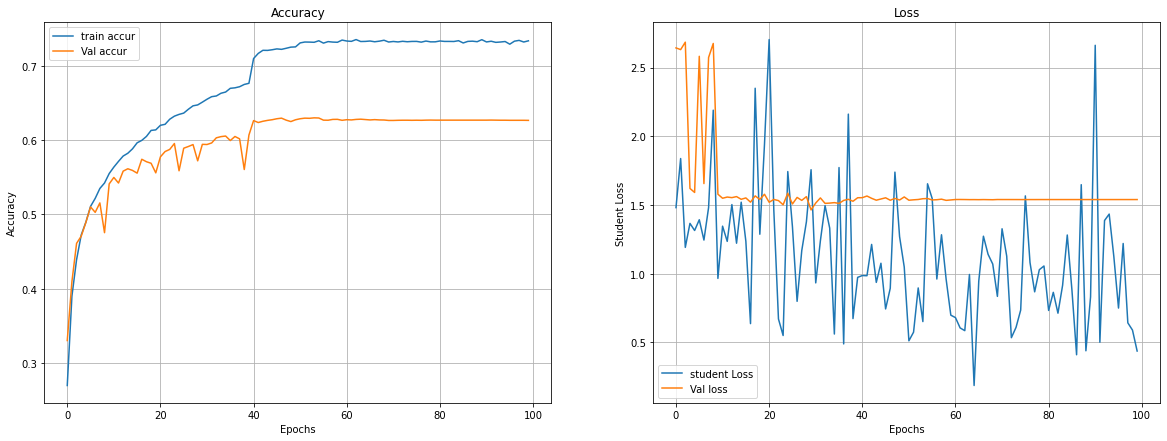

Saving model 
INFO:tensorflow:Assets written to: Lenet5_KD_temp15/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 64s 40ms/step - sparse_categorical_accuracy: 0.2088 - student_loss: 2.1392 - Dist_loss: 0.2262 - loss: 0.4175 - val_sparse_categorical_accuracy: 0.3030 - val_student_loss: 1.4720 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.3584 - student_loss: 1.8086 - Dist_loss: 0.2057 - loss: 0.3660 - val_sparse_categorical_accuracy: 0.3912 - val_student_loss: 2.4914 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.4172 - student_loss: 1.6748 - Dist_loss: 0.1931 - loss: 0.3413 - val_sparse_categorical_accuracy: 0.4544 - val_student_loss: 2.5299 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.4570 - student_loss: 1.58

Epoch 31/100
1562/1562 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.6151 - student_loss: 1.1693 - Dist_loss: 0.1406 - loss: 0.2434
Epoch 31: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.6151 - student_loss: 1.1695 - Dist_loss: 0.1406 - loss: 0.2435 - val_sparse_categorical_accuracy: 0.5880 - val_student_loss: 2.6443 - lr: 1.0000e-03
Epoch 32/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.6149 - student_loss: 1.1667 - Dist_loss: 0.1405 - loss: 0.2431 - val_sparse_categorical_accuracy: 0.5883 - val_student_loss: 2.6435 - lr: 1.0000e-04
Epoch 33/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.6157 - student_loss: 1.1652 - Dist_loss: 0.1405 - loss: 0.2430 - val_sparse_categorical_accuracy: 0.5886 - val_student_loss: 2.6423 - lr: 1.0000e-04
Epoch 34/100

Epoch 61/100
1562/1562 [==============================] - 62s 39ms/step - sparse_categorical_accuracy: 0.6157 - student_loss: 1.1666 - Dist_loss: 0.1404 - loss: 0.2430 - val_sparse_categorical_accuracy: 0.5893 - val_student_loss: 2.6426 - lr: 1.0000e-06
Epoch 62/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.6154 - student_loss: 1.1661 - Dist_loss: 0.1404 - loss: 0.2430 - val_sparse_categorical_accuracy: 0.5893 - val_student_loss: 2.6426 - lr: 1.0000e-06
Epoch 63/100
1562/1562 [==============================] - 62s 39ms/step - sparse_categorical_accuracy: 0.6183 - student_loss: 1.1638 - Dist_loss: 0.1404 - loss: 0.2428 - val_sparse_categorical_accuracy: 0.5893 - val_student_loss: 2.6426 - lr: 1.0000e-06
Epoch 64/100
1562/1562 [==============================] - 62s 39ms/step - sparse_categorical_accuracy: 0.6149 - student_loss: 1.1655 - Dist_loss: 0.1406 - loss: 0.2430 - val_sparse_categorical_accuracy: 0.5893 - val_student_loss: 2.6426 -

1562/1562 [==============================] - 62s 39ms/step - sparse_categorical_accuracy: 0.6157 - student_loss: 1.1666 - Dist_loss: 0.1405 - loss: 0.2431 - val_sparse_categorical_accuracy: 0.5893 - val_student_loss: 2.6427 - lr: 1.0000e-06
Epoch 94/100
1562/1562 [==============================] - 62s 39ms/step - sparse_categorical_accuracy: 0.6159 - student_loss: 1.1660 - Dist_loss: 0.1405 - loss: 0.2431 - val_sparse_categorical_accuracy: 0.5893 - val_student_loss: 2.6428 - lr: 1.0000e-06
Epoch 95/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.6172 - student_loss: 1.1643 - Dist_loss: 0.1405 - loss: 0.2429 - val_sparse_categorical_accuracy: 0.5893 - val_student_loss: 2.6428 - lr: 1.0000e-06
Epoch 96/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.6156 - student_loss: 1.1656 - Dist_loss: 0.1405 - loss: 0.2430 - val_sparse_categorical_accuracy: 0.5893 - val_student_loss: 2.6428 - lr: 1.0000e-

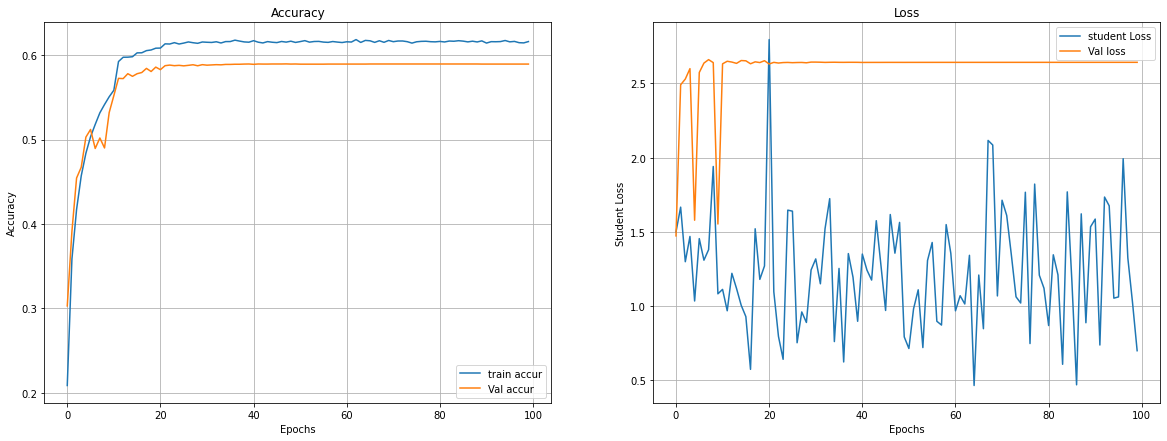

Saving model 
INFO:tensorflow:Assets written to: Lenet5_KD_temp20/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 64s 40ms/step - sparse_categorical_accuracy: 0.2122 - student_loss: 2.1130 - Dist_loss: 0.1370 - loss: 0.3346 - val_sparse_categorical_accuracy: 0.2988 - val_student_loss: 1.5507 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.3621 - student_loss: 1.7779 - Dist_loss: 0.1265 - loss: 0.2916 - val_sparse_categorical_accuracy: 0.3859 - val_student_loss: 2.5493 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 62s 39ms/step - sparse_categorical_accuracy: 0.4270 - student_loss: 1.6142 - Dist_loss: 0.1193 - loss: 0.2688 - val_sparse_categorical_accuracy: 0.4541 - val_student_loss: 2.6256 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.4626 - student_loss: 1.52

Epoch 31/100
1563/1562 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.6063 - student_loss: 1.1574 - Dist_loss: 0.0923 - loss: 0.1988
Epoch 31: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.6063 - student_loss: 1.1576 - Dist_loss: 0.0923 - loss: 0.1989 - val_sparse_categorical_accuracy: 0.5792 - val_student_loss: 1.6401 - lr: 1.0000e-03
Epoch 32/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.6057 - student_loss: 1.1582 - Dist_loss: 0.0923 - loss: 0.1989 - val_sparse_categorical_accuracy: 0.5808 - val_student_loss: 1.6389 - lr: 1.0000e-04
Epoch 33/100
1562/1562 [==============================] - 62s 39ms/step - sparse_categorical_accuracy: 0.6064 - student_loss: 1.1545 - Dist_loss: 0.0923 - loss: 0.1985 - val_sparse_categorical_accuracy: 0.5815 - val_student_loss: 1.6387 - lr: 1.0000e-04
Epoch 34/100

Epoch 61/100
1562/1562 [==============================] - 62s 39ms/step - sparse_categorical_accuracy: 0.6067 - student_loss: 1.1536 - Dist_loss: 0.0922 - loss: 0.1984 - val_sparse_categorical_accuracy: 0.5808 - val_student_loss: 1.6399 - lr: 1.0000e-06
Epoch 62/100
1562/1562 [==============================] - 62s 39ms/step - sparse_categorical_accuracy: 0.6052 - student_loss: 1.1534 - Dist_loss: 0.0923 - loss: 0.1984 - val_sparse_categorical_accuracy: 0.5808 - val_student_loss: 1.6399 - lr: 1.0000e-06
Epoch 63/100
1562/1562 [==============================] - 62s 39ms/step - sparse_categorical_accuracy: 0.6081 - student_loss: 1.1508 - Dist_loss: 0.0922 - loss: 0.1981 - val_sparse_categorical_accuracy: 0.5808 - val_student_loss: 1.6399 - lr: 1.0000e-06
Epoch 64/100
1562/1562 [==============================] - 62s 39ms/step - sparse_categorical_accuracy: 0.6068 - student_loss: 1.1544 - Dist_loss: 0.0923 - loss: 0.1985 - val_sparse_categorical_accuracy: 0.5808 - val_student_loss: 1.6399 -

1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.6067 - student_loss: 1.1540 - Dist_loss: 0.0922 - loss: 0.1984 - val_sparse_categorical_accuracy: 0.5810 - val_student_loss: 1.6400 - lr: 1.0000e-06
Epoch 94/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.6066 - student_loss: 1.1551 - Dist_loss: 0.0923 - loss: 0.1985 - val_sparse_categorical_accuracy: 0.5810 - val_student_loss: 1.6400 - lr: 1.0000e-06
Epoch 95/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.6079 - student_loss: 1.1527 - Dist_loss: 0.0923 - loss: 0.1983 - val_sparse_categorical_accuracy: 0.5810 - val_student_loss: 1.6400 - lr: 1.0000e-06
Epoch 96/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.6077 - student_loss: 1.1514 - Dist_loss: 0.0922 - loss: 0.1982 - val_sparse_categorical_accuracy: 0.5810 - val_student_loss: 1.6400 - lr: 1.0000e-

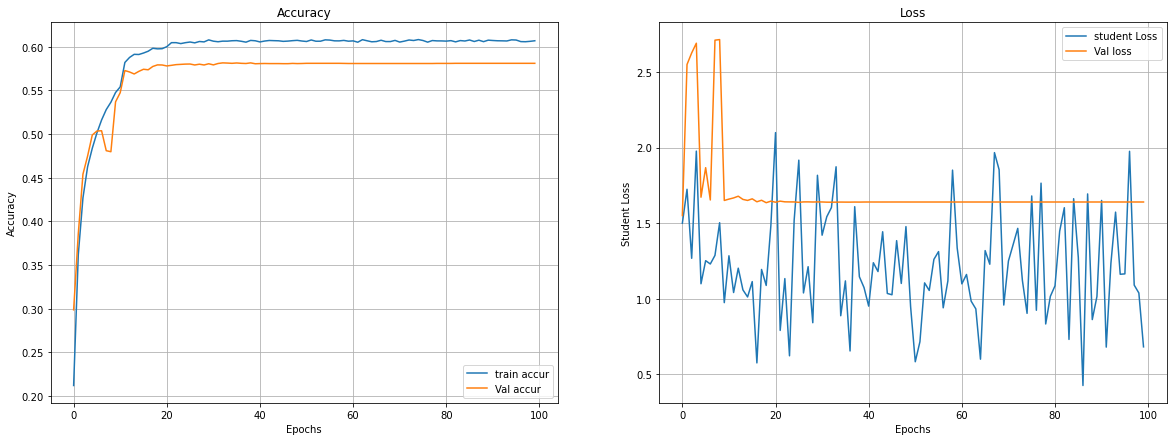

Saving model 
INFO:tensorflow:Assets written to: Lenet5_KD_temp25/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 65s 40ms/step - sparse_categorical_accuracy: 0.2424 - student_loss: 2.0508 - Dist_loss: 0.0897 - loss: 0.2858 - val_sparse_categorical_accuracy: 0.3069 - val_student_loss: 1.4697 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.3607 - student_loss: 1.7774 - Dist_loss: 0.0841 - loss: 0.2534 - val_sparse_categorical_accuracy: 0.3843 - val_student_loss: 2.3808 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.4131 - student_loss: 1.6375 - Dist_loss: 0.0806 - loss: 0.2363 - val_sparse_categorical_accuracy: 0.4406 - val_student_loss: 2.4788 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.4504 - student_loss: 1.54

Epoch 31/100
1562/1562 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.5993 - student_loss: 1.1521 - Dist_loss: 0.0644 - loss: 0.1732
Epoch 31: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.5993 - student_loss: 1.1523 - Dist_loss: 0.0644 - loss: 0.1732 - val_sparse_categorical_accuracy: 0.5722 - val_student_loss: 2.5422 - lr: 1.0000e-03
Epoch 32/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.5985 - student_loss: 1.1522 - Dist_loss: 0.0644 - loss: 0.1732 - val_sparse_categorical_accuracy: 0.5733 - val_student_loss: 2.5441 - lr: 1.0000e-04
Epoch 33/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.5994 - student_loss: 1.1522 - Dist_loss: 0.0644 - loss: 0.1732 - val_sparse_categorical_accuracy: 0.5721 - val_student_loss: 2.5431 - lr: 1.0000e-04
Epoch 34/100

Epoch 61/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.5988 - student_loss: 1.1488 - Dist_loss: 0.0643 - loss: 0.1728 - val_sparse_categorical_accuracy: 0.5725 - val_student_loss: 2.5461 - lr: 1.0000e-06
Epoch 62/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.6004 - student_loss: 1.1476 - Dist_loss: 0.0643 - loss: 0.1727 - val_sparse_categorical_accuracy: 0.5725 - val_student_loss: 2.5461 - lr: 1.0000e-06
Epoch 63/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.6017 - student_loss: 1.1461 - Dist_loss: 0.0643 - loss: 0.1725 - val_sparse_categorical_accuracy: 0.5725 - val_student_loss: 2.5461 - lr: 1.0000e-06
Epoch 64/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.6004 - student_loss: 1.1524 - Dist_loss: 0.0644 - loss: 0.1732 - val_sparse_categorical_accuracy: 0.5725 - val_student_loss: 2.5461 -

1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.5997 - student_loss: 1.1509 - Dist_loss: 0.0643 - loss: 0.1730 - val_sparse_categorical_accuracy: 0.5725 - val_student_loss: 2.5462 - lr: 1.0000e-06
Epoch 94/100
1562/1562 [==============================] - 62s 39ms/step - sparse_categorical_accuracy: 0.6003 - student_loss: 1.1493 - Dist_loss: 0.0644 - loss: 0.1729 - val_sparse_categorical_accuracy: 0.5725 - val_student_loss: 2.5462 - lr: 1.0000e-06
Epoch 95/100
1562/1562 [==============================] - 62s 39ms/step - sparse_categorical_accuracy: 0.5998 - student_loss: 1.1499 - Dist_loss: 0.0644 - loss: 0.1729 - val_sparse_categorical_accuracy: 0.5725 - val_student_loss: 2.5461 - lr: 1.0000e-06
Epoch 96/100
1562/1562 [==============================] - 62s 39ms/step - sparse_categorical_accuracy: 0.5992 - student_loss: 1.1505 - Dist_loss: 0.0644 - loss: 0.1730 - val_sparse_categorical_accuracy: 0.5725 - val_student_loss: 2.5461 - lr: 1.0000e-

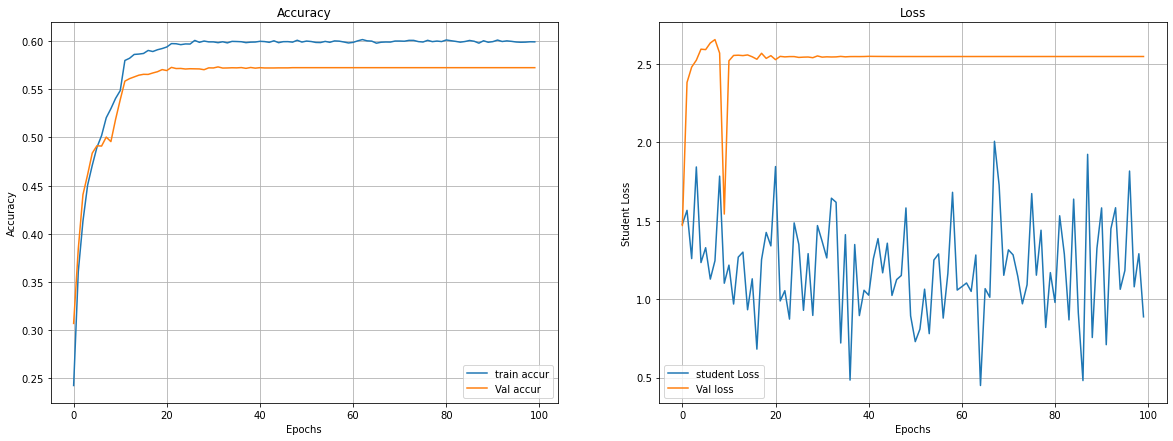

Saving model 
INFO:tensorflow:Assets written to: Lenet5_KD_temp30/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 64s 40ms/step - sparse_categorical_accuracy: 0.2602 - student_loss: 2.0121 - Dist_loss: 0.0629 - loss: 0.2578 - val_sparse_categorical_accuracy: 0.3370 - val_student_loss: 1.5269 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 62s 39ms/step - sparse_categorical_accuracy: 0.3848 - student_loss: 1.7174 - Dist_loss: 0.0588 - loss: 0.2246 - val_sparse_categorical_accuracy: 0.4113 - val_student_loss: 2.4573 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 62s 39ms/step - sparse_categorical_accuracy: 0.4368 - student_loss: 1.5761 - Dist_loss: 0.0564 - loss: 0.2084 - val_sparse_categorical_accuracy: 0.4510 - val_student_loss: 2.5312 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.4668 - student_loss: 1.49

Epoch 31/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.6442 - student_loss: 1.0250 - Dist_loss: 0.0437 - loss: 0.1418 - val_sparse_categorical_accuracy: 0.6002 - val_student_loss: 1.6071 - lr: 1.0000e-03
Epoch 32/100
1562/1562 [==============================] - 62s 39ms/step - sparse_categorical_accuracy: 0.6439 - student_loss: 1.0223 - Dist_loss: 0.0436 - loss: 0.1415 - val_sparse_categorical_accuracy: 0.5998 - val_student_loss: 1.6058 - lr: 1.0000e-03
Epoch 33/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.6432 - student_loss: 1.0253 - Dist_loss: 0.0437 - loss: 0.1418 - val_sparse_categorical_accuracy: 0.5996 - val_student_loss: 1.6041 - lr: 1.0000e-03
Epoch 34/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.6432 - student_loss: 1.0240 - Dist_loss: 0.0436 - loss: 0.1417 - val_sparse_categorical_accuracy: 0.5990 - val_student_loss: 1.6045 -

Epoch 61/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.6474 - student_loss: 1.0184 - Dist_loss: 0.0435 - loss: 0.1410 - val_sparse_categorical_accuracy: 0.6008 - val_student_loss: 1.6074 - lr: 1.0000e-06
Epoch 62/100
1562/1562 [==============================] - 62s 39ms/step - sparse_categorical_accuracy: 0.6475 - student_loss: 1.0165 - Dist_loss: 0.0435 - loss: 0.1408 - val_sparse_categorical_accuracy: 0.6008 - val_student_loss: 1.6074 - lr: 1.0000e-06
Epoch 63/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.6450 - student_loss: 1.0205 - Dist_loss: 0.0435 - loss: 0.1412 - val_sparse_categorical_accuracy: 0.6008 - val_student_loss: 1.6074 - lr: 1.0000e-06
Epoch 64/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.6478 - student_loss: 1.0181 - Dist_loss: 0.0435 - loss: 0.1410 - val_sparse_categorical_accuracy: 0.6008 - val_student_loss: 1.6074 -

1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.6469 - student_loss: 1.0194 - Dist_loss: 0.0435 - loss: 0.1411 - val_sparse_categorical_accuracy: 0.6007 - val_student_loss: 1.6077 - lr: 1.0000e-06
Epoch 94/100
1562/1562 [==============================] - 62s 39ms/step - sparse_categorical_accuracy: 0.6479 - student_loss: 1.0182 - Dist_loss: 0.0435 - loss: 0.1410 - val_sparse_categorical_accuracy: 0.6007 - val_student_loss: 1.6077 - lr: 1.0000e-06
Epoch 95/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.6461 - student_loss: 1.0171 - Dist_loss: 0.0435 - loss: 0.1409 - val_sparse_categorical_accuracy: 0.6007 - val_student_loss: 1.6077 - lr: 1.0000e-06
Epoch 96/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.6457 - student_loss: 1.0170 - Dist_loss: 0.0435 - loss: 0.1408 - val_sparse_categorical_accuracy: 0.6007 - val_student_loss: 1.6077 - lr: 1.0000e-

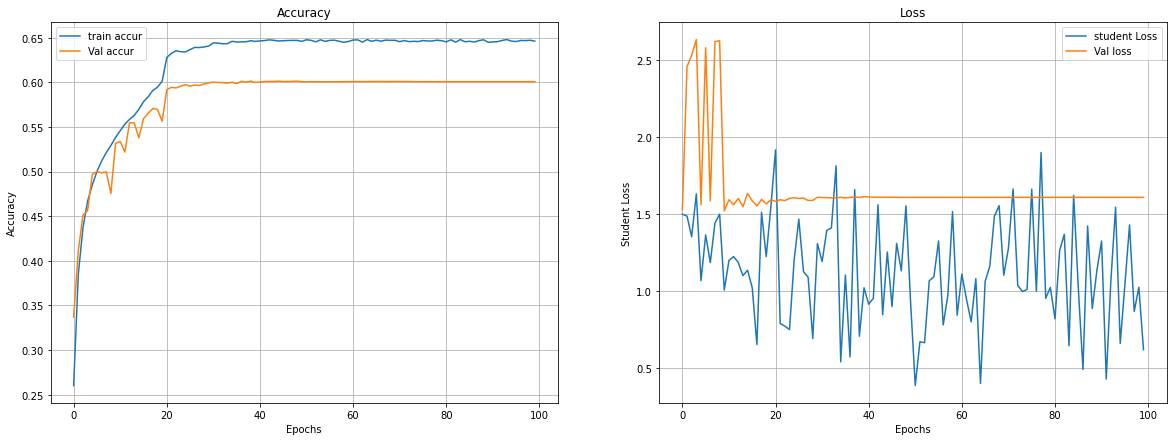

Saving model 
INFO:tensorflow:Assets written to: Lenet5_KD_temp35/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 64s 40ms/step - sparse_categorical_accuracy: 0.2319 - student_loss: 2.0920 - Dist_loss: 0.0474 - loss: 0.2518 - val_sparse_categorical_accuracy: 0.3074 - val_student_loss: 1.3892 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.3699 - student_loss: 1.7655 - Dist_loss: 0.0442 - loss: 0.2163 - val_sparse_categorical_accuracy: 0.3900 - val_student_loss: 3.3398 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.4205 - student_loss: 1.6322 - Dist_loss: 0.0427 - loss: 0.2017 - val_sparse_categorical_accuracy: 0.4328 - val_student_loss: 2.4701 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.4497 - student_loss: 1.54

Epoch 31/100
1563/1562 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.5960 - student_loss: 1.1561 - Dist_loss: 0.0357 - loss: 0.1477
Epoch 31: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.5960 - student_loss: 1.1562 - Dist_loss: 0.0357 - loss: 0.1477 - val_sparse_categorical_accuracy: 0.5720 - val_student_loss: 2.4871 - lr: 1.0000e-03
Epoch 32/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.5926 - student_loss: 1.1564 - Dist_loss: 0.0357 - loss: 0.1478 - val_sparse_categorical_accuracy: 0.5728 - val_student_loss: 2.4869 - lr: 1.0000e-04
Epoch 33/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.5931 - student_loss: 1.1549 - Dist_loss: 0.0357 - loss: 0.1476 - val_sparse_categorical_accuracy: 0.5734 - val_student_loss: 2.4862 - lr: 1.0000e-04
Epoch 34/100

Epoch 61/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.5937 - student_loss: 1.1552 - Dist_loss: 0.0357 - loss: 0.1476 - val_sparse_categorical_accuracy: 0.5740 - val_student_loss: 2.4867 - lr: 1.0000e-06
Epoch 62/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.5937 - student_loss: 1.1557 - Dist_loss: 0.0357 - loss: 0.1477 - val_sparse_categorical_accuracy: 0.5739 - val_student_loss: 2.4867 - lr: 1.0000e-06
Epoch 63/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.5952 - student_loss: 1.1556 - Dist_loss: 0.0357 - loss: 0.1477 - val_sparse_categorical_accuracy: 0.5739 - val_student_loss: 2.4867 - lr: 1.0000e-06
Epoch 64/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.5936 - student_loss: 1.1553 - Dist_loss: 0.0357 - loss: 0.1476 - val_sparse_categorical_accuracy: 0.5739 - val_student_loss: 2.4867 -

1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.5933 - student_loss: 1.1551 - Dist_loss: 0.0357 - loss: 0.1476 - val_sparse_categorical_accuracy: 0.5738 - val_student_loss: 2.4869 - lr: 1.0000e-06
Epoch 94/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.5932 - student_loss: 1.1573 - Dist_loss: 0.0357 - loss: 0.1478 - val_sparse_categorical_accuracy: 0.5738 - val_student_loss: 2.4869 - lr: 1.0000e-06
Epoch 95/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.5939 - student_loss: 1.1544 - Dist_loss: 0.0357 - loss: 0.1475 - val_sparse_categorical_accuracy: 0.5738 - val_student_loss: 2.4869 - lr: 1.0000e-06
Epoch 96/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.5929 - student_loss: 1.1543 - Dist_loss: 0.0357 - loss: 0.1475 - val_sparse_categorical_accuracy: 0.5738 - val_student_loss: 2.4869 - lr: 1.0000e-

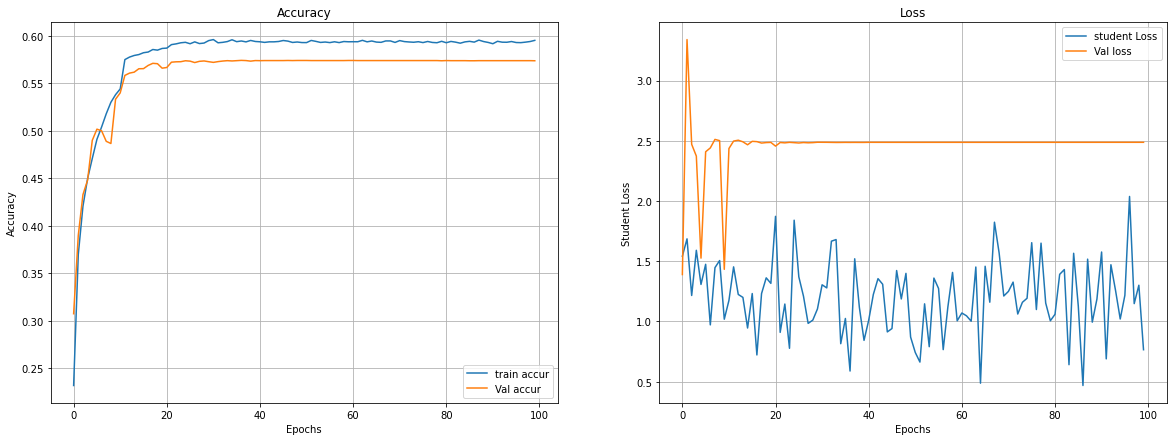

Saving model 
INFO:tensorflow:Assets written to: Lenet5_KD_temp40/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 64s 40ms/step - sparse_categorical_accuracy: 0.1811 - student_loss: 2.2002 - Dist_loss: 0.0066 - loss: 0.2260 - val_sparse_categorical_accuracy: 0.2766 - val_student_loss: 1.4769 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.3315 - student_loss: 1.8404 - Dist_loss: 0.0061 - loss: 0.1896 - val_sparse_categorical_accuracy: 0.3614 - val_student_loss: 2.5207 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.3985 - student_loss: 1.6740 - Dist_loss: 0.0059 - loss: 0.1727 - val_sparse_categorical_accuracy: 0.4253 - val_student_loss: 1.5623 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.4308 - student_loss: 1.58

Epoch 31/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.6308 - student_loss: 1.0550 - Dist_loss: 0.0049 - loss: 0.1099 - val_sparse_categorical_accuracy: 0.5945 - val_student_loss: 1.4911 - lr: 1.0000e-03
Epoch 32/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.6309 - student_loss: 1.0537 - Dist_loss: 0.0049 - loss: 0.1098 - val_sparse_categorical_accuracy: 0.5944 - val_student_loss: 1.4882 - lr: 1.0000e-03
Epoch 33/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.6295 - student_loss: 1.0551 - Dist_loss: 0.0049 - loss: 0.1100 - val_sparse_categorical_accuracy: 0.5942 - val_student_loss: 1.4872 - lr: 1.0000e-03
Epoch 34/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.6313 - student_loss: 1.0515 - Dist_loss: 0.0049 - loss: 0.1096 - val_sparse_categorical_accuracy: 0.5938 - val_student_loss: 1.4812 -

Epoch 61/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.6319 - student_loss: 1.0504 - Dist_loss: 0.0049 - loss: 0.1095 - val_sparse_categorical_accuracy: 0.5936 - val_student_loss: 1.4907 - lr: 1.0000e-06
Epoch 62/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.6324 - student_loss: 1.0505 - Dist_loss: 0.0049 - loss: 0.1095 - val_sparse_categorical_accuracy: 0.5936 - val_student_loss: 1.4907 - lr: 1.0000e-06
Epoch 63/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.6326 - student_loss: 1.0495 - Dist_loss: 0.0049 - loss: 0.1094 - val_sparse_categorical_accuracy: 0.5936 - val_student_loss: 1.4907 - lr: 1.0000e-06
Epoch 64/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.6325 - student_loss: 1.0484 - Dist_loss: 0.0049 - loss: 0.1093 - val_sparse_categorical_accuracy: 0.5936 - val_student_loss: 1.4907 -

1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.6307 - student_loss: 1.0510 - Dist_loss: 0.0049 - loss: 0.1095 - val_sparse_categorical_accuracy: 0.5936 - val_student_loss: 1.4909 - lr: 1.0000e-06
Epoch 94/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.6338 - student_loss: 1.0490 - Dist_loss: 0.0049 - loss: 0.1093 - val_sparse_categorical_accuracy: 0.5936 - val_student_loss: 1.4909 - lr: 1.0000e-06
Epoch 95/100
1562/1562 [==============================] - 62s 39ms/step - sparse_categorical_accuracy: 0.6321 - student_loss: 1.0492 - Dist_loss: 0.0049 - loss: 0.1093 - val_sparse_categorical_accuracy: 0.5936 - val_student_loss: 1.4909 - lr: 1.0000e-06
Epoch 96/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.6330 - student_loss: 1.0486 - Dist_loss: 0.0049 - loss: 0.1093 - val_sparse_categorical_accuracy: 0.5936 - val_student_loss: 1.4909 - lr: 1.0000e-

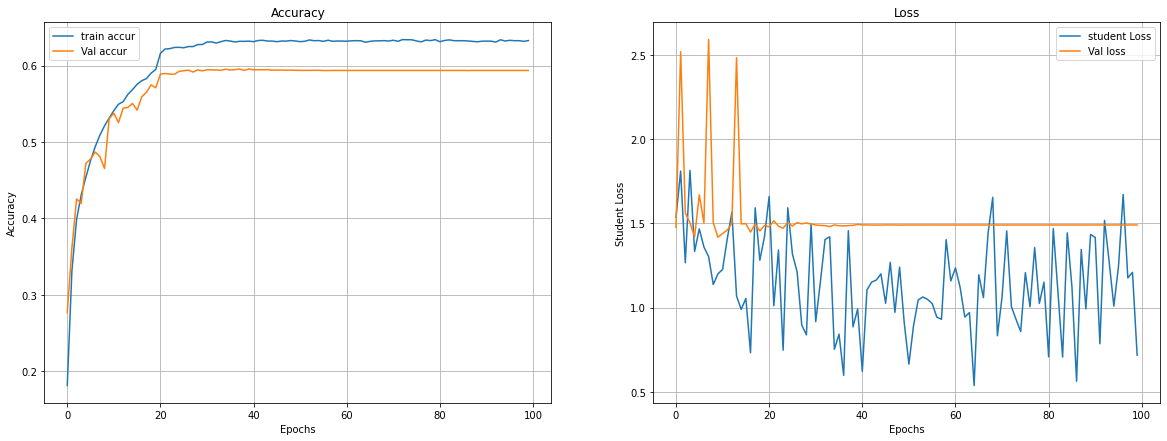

Saving model 
INFO:tensorflow:Assets written to: Lenet5_KD_temp100/assets
Saving Done !
Saving Weights 
Saving Done !

End !


In [11]:
for t in T:
    # Configuration du tensorboard
    NAME = f"Lenet5_kd_alpha_{0.1}_temp_{t}"
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir = f"logs/{NAME}", 
                                                 histogram_freq = 1)
    
    student_test = tf.keras.models.clone_model(student)

    dist = Distiller(teacher, student_test)

    dist.compile(
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr),
        metrics = [tf.keras.metrics.SparseCategoricalAccuracy()],
        distillation_loss_fn = tf.keras.losses.KLDivergence(),
        student_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        alpha = 0.1,
        temperature = t)

    # Train and evaluate on data.
    hist = dist.fit(x_train, y_train, 
          batch_size = BATCH_SIZE,
          epochs=EPOCHS,
          steps_per_epoch = len(x_train)/BATCH_SIZE,
          validation_data =(x_test, y_test),
          workers =40,
          use_multiprocessing= True,
          callbacks = [lr_reduce, tensorboard],
          )


    dist.evaluate(x_test, y_test)
    print("")

    print(" =============== History Plot ===============")
    plot_hist_kd(hist, f"Lenet5_KD_temp{t}.png")


    print("Saving model ")
    student_test.save(f"Lenet5_KD_temp{t}")
    print("Saving Done !")

    print("Saving Weights ")
    student_test.save_weights(f"w_Lenet5_temp_{t}.h5")
    print("Saving Done !")
    print("")

    print("End !")